In [1]:
import os
from time import time
import numpy as np
import sys
sys.path.append('../')

from utils.codification_cnn import FitnessCNN, FitnessCNNParallel, NNLayer
from utils.codification_cell import CNNLayer_WOMP, ChromosomeFilterGrow
from utils.datamanager import DataManager
from utils.codification_skipc import Connections
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA, TwoLevelGA

Using TensorFlow backend.


In [2]:
# Chromosome parameters
mutation_rate = 0.1
mutation_rate_1 = mutation_rate * 2
ChromosomeFilterGrow.grow_prob = mutation_rate_1
ChromosomeFilterGrow.decrease_prob = mutation_rate_1
ChromosomeFilterGrow.skip_prob = 0.1

CNNLayer_WOMP.k_prob = mutation_rate
CNNLayer_WOMP.filter_prob = mutation_rate_1
CNNLayer_WOMP.act_prob = mutation_rate

NNLayer.units_prob = mutation_rate_1
NNLayer.act_prob = mutation_rate
NNLayer.drop_prob = mutation_rate_1

ChromosomeFilterGrow.num_blocks = 3
ChromosomeFilterGrow.initial_filters = 32


data_folder = '../../datasets'
command = 'python3 ./../train_gen.py'
verbose = 0
experiments_folder = '../../exps'
gpus = 2
'''
data_folder = '/home/daniel/datasets/MNIST_variations'
command = 'python ./../train_gen.py'
verbose = 1
experiments_folder = '../../exps'
gpus = 1
'''

"\ndata_folder = '/home/daniel/datasets/MNIST_variations'\ncommand = 'python ./../train_gen.py'\nverbose = 1\nexperiments_folder = '../../exps'\ngpus = 1\n"

In [3]:
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)

fitness_cnn = FitnessCNN()

In [4]:
l = CNNLayer_WOMP(1.0, 3, 'relu')
l2 = CNNLayer_WOMP(1.2, 3, 'relu')
l3 = NNLayer(128, 'relu', 0.5)
cnn_layers = [l, l2]
c = ChromosomeFilterGrow(cnn_layers, [l3], Connections.random_connections(len(cnn_layers)))
d = c.random_individual()

In [5]:
print(d)

CNN|F:0.5|K:5|A:sigmoid
CNN|F:1.0|K:7|A:leakyreLu
CNN|F:1.2|K:3|A:elu
CNN|F:1.4|K:1|A:prelu
NN|U:284|A:sigmoid|D:0.594
1
11
001



In [6]:
# m = d.decode(input_shape=(28,28,1), num_classes=10, verb=True)

In [7]:
# dataset params:
data_folder = data_folder
classes = []

# genetic algorithm params:
N = 30
generations = N 
population_first_level = N
population_second_level = int(0.6 * N)
training_hours = 120
save_progress = True
maximize_fitness = False
statistical_validation = False
frequency_second_level = 1
start_level2 = 1


# Fitness params
epochs = 20
batch_size = 128
verbose = verbose
redu_plat = False
early_stop = 0
warm_up_epochs= 0
base_lr = 0.01
smooth = 0.1
cosine_dec = False
lr_find = False
precise_eps = 75

datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
datasets = ['cifar10']

In [8]:
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)

    # Load data
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
    data = dm.load_data()
    fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                   precise_epochs=precise_eps)

    fitness_cnn.save(fitness_file)

    del dm, data
    
    fitness = FitnessCNNParallel()
    fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                   fp=32, main_line=command)
    generational = TwoLevelGA(chromosome=c,
                              fitness=fitness,
                              generations=generations,
                              population_first_level=population_first_level,
                              population_second_level=population_second_level,
                              training_hours=training_hours,
                              save_progress=save_progress,
                              maximize_fitness=maximize_fitness,
                              statistical_validation=statistical_validation,
                              folder=folder,
                              start_level2=start_level2,
                              frequency_second_level=frequency_second_level)
        
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))


EVOLVING IN DATASET cifar10 ...

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples
Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 50
Population size: 50
Folder to save: ../../exps/cifar10/genetic/0_2019-10-30-19:36/GA_experiment
num parents: 12
offspring size: 38

Population size level one: 50
Population size level two: 30
Number of parents level one: 12
Number of parents level two: 15
Offspring size level one: 38
Offspring size level two: 15
Creating Initial population

Start evolution process...


0) Ranking level 1... Models to train: 50 ...OK (in 108.49 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 1... Models to train: 34 ...OK (in 103.63 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 2... Models to train: 30 ...OK (in 433.22 minutes)
Saving... Elapsed saved time: 0.001

2) R

KeyboardInterrupt: 

In [ ]:
ranking1 = generational.evaluate_population(level=1)
ranking2 = generational.evaluate_population(level=2)

Best Gen -> 
CNN|F:1.3|K:3|A:leakyreLu
CNN|F:1.2|K:7|A:leakyreLu
CNN|F:1.2|K:3|A:leakyreLu
CNN|F:1.1|K:1|A:relu
CNN|F:0.8|K:3|A:relu
1
01
001
1001

With Fitness (val): 0.1037 and (test): 0.1142


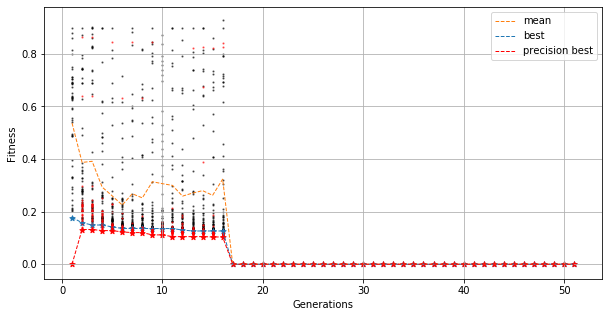

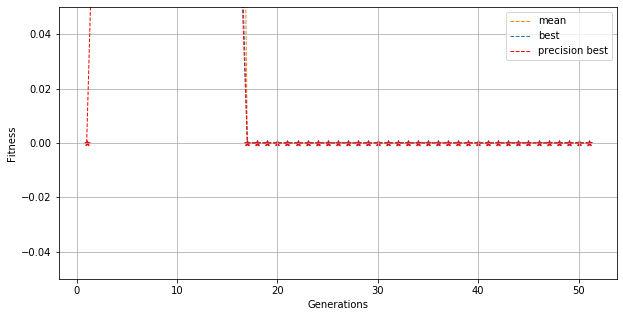

In [9]:
winner, fit_test = generational.finishing_evolution(show=True)

In [ ]:
ranking2

In [ ]:
w = generational.best_individual['winner']

In [ ]:
print(generational.history_fitness[w.__repr__()])
print(generational.history_precision_fitness[w.__repr__()])

In [ ]:
generational.best_individual

In [ ]:
for k,f in generational.history_precision_fitness.items():
    print(k,f, end="\n"*2)

In [ ]:
from keras import Input, Model
from keras.layers import Conv2D, PReLU, LeakyReLU, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization
import numpy as np
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



In [ ]:
x_train, x_val = np.random.rand(1000, 28, 28, 1), np.random.rand(200, 28, 28, 1)
y_train, y_val = np.random.randint(0, 2, (1000, 10)), np.random.randint(0, 2, (200, 10))
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

In [ ]:
inp = Input((28,28,1))
x = Conv2D(32, 3, activation='relu', padding='same')(inp)
x = MaxPooling2D()(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(10)(x)
model = Model(inp, x)
model.summary()
model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])

c = ModelCheckpoint('.delete_this_model', monitor='val_accuracy', save_best_only=True)
h = model.fit(x_train, y_train,
            batch_size=32,
            epochs=5,
            verbose=1,
            validation_data=(x_val, y_val),
             callbacks=[c])

In [ ]:
import keras

print(keras.__version__)

In [ ]:
val_acc = 'val_accuracy' if keras.__version__ == '2.3.1' else 'val_acc'
print(val_acc)

In [ ]:
h.model


In [ ]:
h.on_batch_begin

In [ ]:
type(h.history)

In [ ]:
h.history.keys()

In [ ]:
for key in h.history.keys():
    if 'val_acc' in key:
        print(key)

In [ ]:
key_val_acc = [key for key in h.history.keys() if 'val_acc' in key][0]
print(key_val_acc)

In [ ]:
fitness_cnn.verb = 1
fitness_cnn.calc(winner, test=True)